In [5]:
import os 

import nibabel as nib
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from cfl.util import fear_mice_functions as fm
import cfl.util.brain_util as BU
import cfl.util.brain_vis as BV

mri_dir, mri_dims, affine, dir_labels = fm.get_global_values()
behav_csv = 'PTSD_Data_Share\Behavior_data\PTSD_PerLight.csv'

In [6]:
# load response data 
Y = pd.read_pickle('Y.pkl')

# # load MRIs (uncomment this to load smoothed MRIs, generated with smooth_data.ipynb)
# X = np.load('smooth_X_paper_sigma.npy')
# data_id = 'smooth_X_'
# save_folder = os.path.join('npy_files', 'smooth')

X, Y_unused = BU.load_data(mri_dir, behav_csv, mri_dims, ori='RPS')
data_id = 'X_'
save_folder = os.path.join('npy_files')

In [7]:
# orientation and shape of atlas match the MRI images we've been looking at
nib_atlas = nib.load(os.path.join('PTSD_Data_Share', "PTSD_InVivoAtlas_labels.nii"))
print(nib.orientations.aff2axcodes(nib_atlas.affine))
print(nib_atlas.shape)

('R', 'P', 'S')
(124, 200, 82)


In [8]:
# load image in RPS orientation 
atlas = BU.load_brain(os.path.join('PTSD_Data_Share', "PTSD_InVivoAtlas_labels.nii"), ori='RPS')

In [9]:
flatlas = BU.flatten(atlas)

In [10]:
print(np.unique(atlas))
print("Length:", len(np.unique(atlas)))
missing_vals = [14, 23, 24, 36, 56, 62]
print("Missing:", str(missing_vals))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  15.  16.  17.  18.  19.  20.  21.  22.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  57.  58.  59.  60.
  61.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111.]
Length: 106
Missing: [14, 23, 24, 36, 56, 62]


In [11]:
# #histogram of how many voxels are part of each region 
# plt.hist(BU.flatten(atlas), bins=111)
# plt.show()

In [12]:
# # same histogram, excluding 0s (empty space)
# plt.hist(BU.flatten(atlas), bins=110, range=(1, 112))
# plt.show()

In [13]:
regions = (np.unique(atlas)[1:])

freqs = np.array([np.sum(np.equal(atlas, region)) for region in regions])

#sort in descending order
sort_inds = np.flip(np.argsort(freqs))
sorted_regions = regions.ravel()[sort_inds.reshape(regions.shape)]
sorted_freqs = freqs.ravel()[sort_inds.reshape(freqs.shape)]

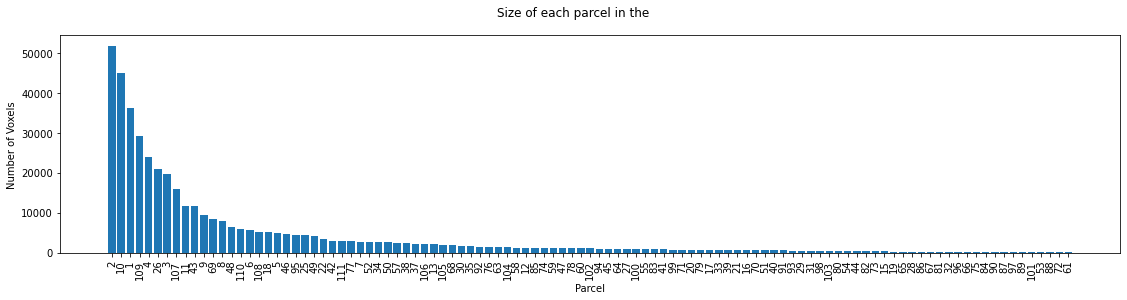

In [14]:
plt.figure(figsize=(19, 4))
plt.bar(sorted_regions.astype(int).astype(str), height=sorted_freqs)
plt.xticks(rotation=90)
plt.suptitle("Size of each parcel in the")
plt.ylabel("Number of Voxels")
plt.xlabel("Parcel")
plt.show()

In [15]:
# specify labels for plot (note the labels below are specifically for RAS orientation)

# generate interactive plots
# BV.plot_interactive_panels(BU.flatten(atlas), atlas.shape, np.ones(np.prod(atlas.shape)), figsize=(12, 3), colormap='nipy_spectral', std_scale='std', dir_labels=dir_labels)


In [16]:
# generate interactive plots
# BV.plot_interactive_panels(BU.flatten(atlas), atlas.shape, np.ones(np.prod(atlas.shape)), figsize=(12, 3), colormap='prism', std_scale='std', dir_labels=dir_labels)

# Visualize individual regions of atlas 

In [17]:
### This isn't very easy to do with our visualization. It's easier to visualize the shapes of regions by loading the atlas in FSL 

# What regions do the atlas numbers correspond to?

In [20]:
import pandas as pd
import os

atlas_names_df = pd.read_excel(os.path.join(os.getcwd(), 'PTSD_Data_Share', 'PTSD_InVivoAtlas_labels_grouping_mod.xlsx'))

# create a dictionary between the abbreviations and the names 
num_to_abbr = atlas_names_df.groupby('Original_Invivo_Index')['Abbr'].apply(list).to_dict()
for key in num_to_abbr: 
    num_to_abbr[key] = num_to_abbr[key][0]

# same for full names 
num_to_name = atlas_names_df.groupby('Original_Invivo_Index')['Full_Segment_Filename'].apply(list).to_dict()
for key in num_to_abbr: 
    num_to_name[key] = num_to_name[key][0]

In [21]:
def nums_to_abbrs(array, dict):
    new = []
    for i, item in enumerate(array): 
        if item in dict: 
            new.append(dict[item])
        else: 
            new.append(str(int(item)))
    return new

In [22]:
def sort_for_bar_graph(regions, vals, dec=True): 
    '''sort two aligned arrays in the same order based on the value of vals.
    dec is true if they should be sorted in decreasing order, otherwise ascending order'''
    sort_inds = np.argsort(vals)
    if dec: 
        sort_inds = np.flip(sort_inds)
    sorted_regions = regions.ravel()[sort_inds.reshape(regions.shape)]
    sorted_vals = vals.ravel()[sort_inds.reshape(vals.shape)]
    return sorted_regions, sorted_vals

sorted_abbrs = nums_to_abbrs(sorted_regions, num_to_abbr)

def find_regions(region_name):
    # find matches to region_name in the full names for the atlas  
    matching_fullnames = atlas_names_df['Grouping'].str.contains(region_name)

    #get the numbers (as seen in atlas) for those regions 
    region_numbers = atlas_names_df.Original_Invivo_Index[matching_fullnames].to_numpy()
    return region_numbers


def print_location(region_numbers, i=10):
    # i is just a value to pick so you don't pick the very very corner of the region. The default should be fine
    #use these to find where the regions are in FSL 
    for region in region_numbers: 
        where = np.where(atlas==region)
        if len(where[0])>0:
            print("A voxel in region {}: ({}, {}, {})".format(region, where[0][i], where[1][i], where[2][i]))
        else:
            print('Region {} is size 0'.format(region))



# Reproducing Results from the Paper

## Supplementary Figures 4 + 5 

In [23]:
#load fear minus prefear diffs (run the fear minus pref notebook first)

arrays = []
for genotype in ['all', 'KO', 'WT']: 
    savepath = os.path.join(save_folder, data_id + 'fear_minus_pref_' + genotype + '.npy')
    arrays.append(np.load(savepath))

diffs_all, diffs_KO, diffs_WT = arrays



In [24]:
# load the heatmaps
all_HM_dir = fm.empty_geno_time_dir(Y, mri_dims)
for key in all_HM_dir: 
    all_HM_dir[key] = np.load(os.path.join(save_folder, data_id + 'heatmap_' + key + '.npy'))

In [25]:
def significant_voxels(baseline_mri, other_mri, percent_diff, both):
    """ 
    baseline and mri should be flattened

    Calculate an array of significantly changed voxels from the baseline 
    to the other MRI. Returns array with same shape as original MRIs, where 
    0 = no sig change from baseline to other, 1 = sig increase and -1 = sig decrease 

    percent_diff is the decimal change in activation between the baseline and other mri 
    that needs to be reached for a voxel to be 'significant'

    if both: calculate both increases and decreases. otherwise: just increases 
    """ 
    n_voxels = np.prod(other_mri.shape)

    signif_array = np.zeros(n_voxels) 
    for voxel in range(n_voxels): 
        threshold = percent_diff * baseline_mri[voxel]
        if other_mri[voxel] >threshold + baseline_mri[voxel]: # sig increase
            signif_array[voxel] = 1
        if both: #sig decrease 
            if other_mri[voxel] < threshold - baseline_mri[voxel]: 
                signif_array[voxel] = -1
    return signif_array

def activation_ratios(baseline_mri, other_mri, regions, percent_diff, both=False):
    '''calculate the activation ratio for all regions for the given MRI. 
    Returns an array of the same length as regions'''

    signif_array = significant_voxels(baseline_mri, other_mri, percent_diff, both)
    # calculate ratio of sig voxels to overall for each region 
    act_ratios = np.zeros(regions.shape)
    for i, region in enumerate(regions): 
        all_voxels = np.sum(atlas == region)
        sig_voxels = np.sum(np.not_equal(signif_array[flatlas == region], 0))
        act_ratios[i] = np.divide(sig_voxels, all_voxels)
    return act_ratios


# write another function that 
# extracts the WT, KO Pre-f, Fear activation ratios 
def fear_pref_WT_KO_activation_ratios(heatmap_dir, regions, percent_diff, both=False):     
    # return a dict of 4 arrays: activation_ratios for:  WT pre-F, WT fear, KO pre-f, KO fear
    return_stuff = {'PreF_WT': np.array(X[0].shape), 'Fear_WT': np.array(X[0].shape), 'PreF_KO' :np.array(X[0].shape), 'Fear_KO': np.array(X[0].shape)}

    for combo in return_stuff:
        timepoint, genotype = combo.split(sep='_')
        bl = heatmap_dir['BL_' + genotype]
        other = heatmap_dir[combo]
        return_stuff[combo] = activation_ratios(bl, other, regions, percent_diff, both)

    return return_stuff

In [26]:

bl= all_HM_dir["BL_KO"]
fear_ko = all_HM_dir["Fear_KO"]

In [27]:
fear_ko

array([0., 0., 0., ..., 0., 0., 0.])

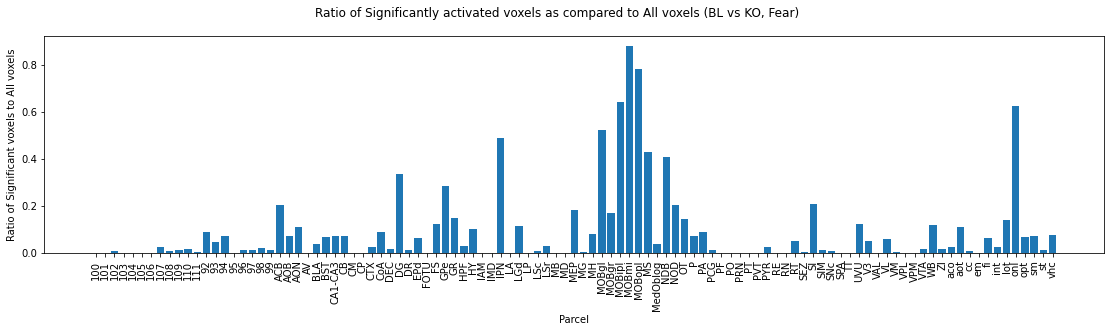

In [31]:
abbbrs = nums_to_abbrs(regions, num_to_abbr)

# determine significant voxels by picking those changed by at least 10 %
percent_diff = 0.1 #arbitrarily chosen
signess_ratios = activation_ratios(bl, fear_ko, regions, percent_diff, both=False)
sorted_ratios, sorted_abbrs = sort_for_bar_graph(signess_ratios, np.array(abbbrs), dec=False)


fig, ax = plt.subplots(figsize=(19, 4))
plt.bar(sorted_abbrs, height=sorted_ratios)
plt.xticks(rotation=90)
plt.suptitle("Ratio of Significantly activated voxels as compared to All voxels (BL vs {}, {})".format('KO', 'Fear'))
plt.ylabel("Ratio of Significant voxels to All voxels")
plt.xlabel("Parcel")
plt.show()

In [33]:
# TODO : 
#- pull out specific regions (amygdala and olfactory )
#     - if you get those results, you can recreate fig 7 
#- make this same graph for all the other time points and genotypes (8 total)
#- (do this by putting the functions into actual functions) 
#- change the graph to be vertical 

# should i be considering 'increased and decreased activity ' voxels or just increased? 

## Table 2

In [35]:
# boolean series of which elements are in Table 2 of the paper 
in_table_2 = atlas_names_df['In_table_2'].astype(str).str.isdecimal()

not_in_table_2 = ~in_table_2

KeyError: 'In_table_2'

In [76]:
table_2_regions = table_2['Original_Invivo_Index'].to_numpy()
table_2_regions

array([ 2., 15., 20., 25., 31., 34., 35., 37., 38., 43., 46., 47., 48.,
       49., 50., 51., 57., 58., 63., 64., 66., 68., 70., 72., 77., 78.,
       87., 89.])

In [80]:
# select only the rows that are in the table 
table_2 = atlas_names_df[in_table_2]

# create new df, with name and abbr from og df 

new_df = table_2.loc[:, ["Full_Segment_Filename", "Abbr", "In_table_2", "WT", "SERT"]]

# and then we do the activation ratio from before for each brain region 
table_2_regions = table_2['Original_Invivo_Index'].to_numpy()

activation_ratios = fear_pref_WT_KO_activation_ratios(all_HM_dir, table_2_regions, 0.07, both=False)
# and then we need to make a table of the values for the ones in the table, and see if we get comparable values 
WT_act_diffs = activation_ratios['Fear_WT'] - activation_ratios['PreF_WT']
KO_act_diffs = activation_ratios['Fear_KO'] - activation_ratios['PreF_KO']

new_df.insert(2, "WT_my_results", WT_act_diffs)
new_df.insert(3, "KO_my_results", KO_act_diffs)

# and also make a table of the values that are not in the table, and see that those are also small change 

In [89]:
new_df.sort_values("In_table_2")

,Full_Segment_Filename,Abbr,WT_my_results,KO_my_results,In_table_2,WT,SERT
48,Main olfactory bulb granule layer,MOBgr,0.133791,-0.149183,0,++,++
47,Main olfactory bulb glomerular layer,MOBgl,0.072206,-0.041085,0,++,++
46,Main olfactory bulb outer plexiform layer,MOBopl,0.048738,-0.052219,0,++,++
45,Main olfactory bulb inner plexiform layer,MOBipl,0.011506,-0.091626,0,++,++
33,Anterior olfactory nucleus,AON,0.041713,0.060170,0,++,++
63,Main olfactory bulb mitral layer,MOBmi,0.039643,-0.033697,0,++,++
77,Lateral amygdalar nucleus,LA,0.009865,-0.001794,1,++,+
76,fe,BLA,-0.006076,0.050036,2,+,-
37,Cortical amygdalar area,CoA,0.019316,0.011268,3,++,-
24,nucleus accumbens,ACB,0.181034,0.056942,4,++,+


# Compare atlas regions to pre-fear minus fear activation diffs 

In [11]:
diffs = np.load(os.path.join('npy_files', 'fear_minus_pref_all.npy'))
diffs_KO = np.load(os.path.join('npy_files', 'fear_minus_pref_KO.npy'))
diffs_WT = np.load(os.path.join('npy_files', 'fear_minus_pref_WT.npy'))

In [12]:
flatlas = BU.flatten(atlas)
regions = np.unique(atlas)

# average all the (fear-prefear) diffs that correspond with each region of the atlas
parcel_diffs = np.zeros(regions.shape)
for i, region in enumerate(regions): 
    parcel_diffs[i] = np.average(diffs[flatlas==region])

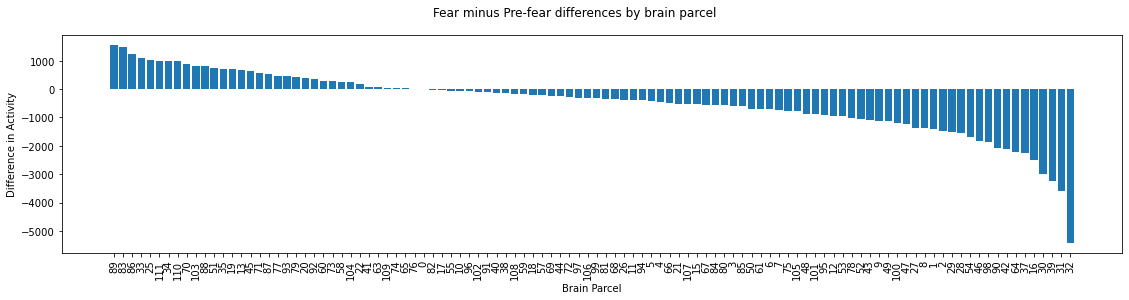

In [16]:
#sort in descending order
sorted_regions, sorted_diffs = sort_for_bar_graph(regions, parcel_diffs)

# make barchart 
plt.figure(figsize=(19, 4))
plt.bar(sorted_regions.astype('int').astype('str'), height=sorted_diffs)
plt.suptitle("Fear minus Pre-fear differences by brain parcel")
plt.ylabel("Difference in Activity")
plt.xlabel("Brain Parcel")
plt.xticks(rotation=90)
plt.show()

# Examining the Fear minus pre-fear diffs for the olfactory bulb and amygdala 

## Find the Amygdala in FSL

In [20]:
amyg_regions = find_regions('Amygdala')
print_location(amyg_regions)

A voxel in region 38: (28, 118, 21)
A voxel in region 44: (32, 120, 25)
A voxel in region 71: (44, 72, 39)
A voxel in region 77: (26, 110, 27)
A voxel in region 78: (22, 112, 34)


In [21]:
# size of each region 
for region in amyg_regions: 
    print("Size of region {}: {}".format(region, np.sum(atlas==region)))

Size of region 38: 2485
Size of region 44: 400
Size of region 71: 761
Size of region 77: 2798
Size of region 78: 1115


## Fear minus Pre-fear diffs of amygdalar regions 

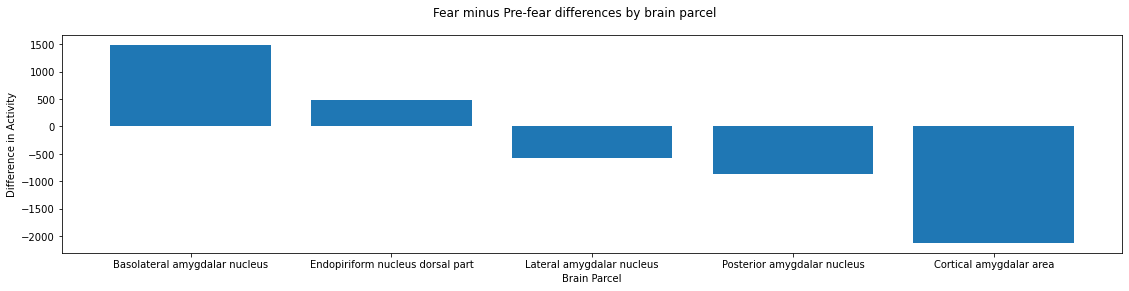

In [63]:
#sort in descending order
sorted_regions, sorted_diffs = sort_for_bar_graph(amyg_regions, parcel_diffs[amyg_regions])
names = nums_to_abbrs(sorted_regions, num_to_name) 
# make barchart 
plt.figure(figsize=(19, 4))
plt.bar(names, height=sorted_diffs)
plt.suptitle("Fear minus Pre-fear differences by brain parcel")
plt.ylabel("Difference in Activity")
plt.xlabel("Brain Parcel")
plt.show()

- which regions are appropriate to include? 
- normalize by region size 
- check the order in which they average/subtract/aggregate 
- check by condition 
- convince ourselves that the sign of everything is correct    (pick out some individual voxels and trace it along the whole way)

- checks on dimensions/flattening 
- clean up pipelines 


SNN speed 
- AWS 
- run locally on some 1-D/2-D data set - even simpler than visual bars - (a couple of Gaussians or something) - see whether it gets two clusters (sanity check - make sure that works) (is the 1D causing problems?)

## Find the Olfactory Bulb

In [133]:
olf_regions = find_regions('Olf')
print_location(_regions)

Region 14 is size 0
A voxel in region 34: (44, 68, 43)
A voxel in region 39: (50, 63, 53)
A voxel in region 40: (53, 53, 60)
A voxel in region 45: (54, 72, 40)
A voxel in region 46: (47, 57, 55)
A voxel in region 47: (45, 54, 56)
A voxel in region 48: (46, 48, 56)
A voxel in region 49: (48, 57, 60)
A voxel in region 64: (47, 53, 59)


In [31]:
olf_regions=find_regions('Olf')

# size of each region 
for region in olf_regions: 
    print("Size of region {}: {}".format(region, np.sum(atlas==region)))

Size of region 14: 0
Size of region 34: 2709
Size of region 39: 682
Size of region 40: 571
Size of region 45: 1024
Size of region 46: 4693
Size of region 47: 1149
Size of region 48: 6523
Size of region 49: 4223
Size of region 64: 1009


In [35]:
#remove region 14, which has size 0 
olf_regions = olf_regions[olf_regions != 14]
olf_regions

array([34, 39, 40, 45, 46, 47, 48, 49, 64], dtype=int64)

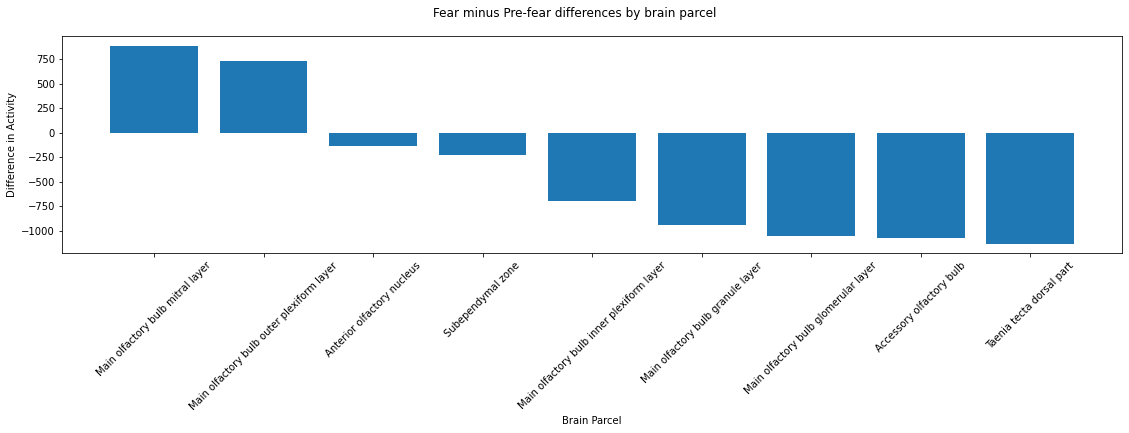

In [61]:
#sort in descending order
sorted_regions, sorted_diffs = sort_for_bar_graph(olf_regions, parcel_diffs[olf_regions])
names = nums_to_abbrs(sorted_regions, num_to_name) 

# make barchart 
plt.figure(figsize=(19, 4))
plt.bar(names, height=sorted_diffs)
plt.suptitle("Fear minus Pre-fear differences by brain parcel")
plt.ylabel("Difference in Activity")
plt.xlabel("Brain Parcel")
plt.xticks(rotation=45)
plt.show()